# Paralelization notebook

In [1]:
import xarray as xr
import numpy as np

import pyxpcm
from pyxpcm.models import pcm

import time

import matplotlib.pyplot as plt

import concurrent.futures
from tqdm import tqdm

### Dataset

In [2]:
#get data
file_path = '/export/home1/agarciaj/datasets/global-reanalysis-phy-001-030-monthly_1601036810235.nc'
ds = xr.open_dataset(file_path)

#some format
ds['depth'] = -np.abs(ds['depth'].values)
ds.depth.attrs['axis'] = 'Z'

var_name = 'thetao' 

ds

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 205, longitude: 577, time: 12)
Coordinates:
  * depth      (depth) float32 -0.494025 -1.541375 ... -5274.784 -5727.917
  * latitude   (latitude) float32 30.0 30.083334 30.166666 ... 46.916668 47.0
  * time       (time) datetime64[ns] 2018-01-16T12:00:00 ... 2018-12-16T12:00:00
  * longitude  (longitude) float32 -6.0 -5.9166665 -5.8333335 ... 41.916668 42.0
Data variables:
    mlotst     (time, latitude, longitude) float32 ...
    vo         (time, depth, latitude, longitude) float32 ...
    thetao     (time, depth, latitude, longitude) float32 ...
    uo         (time, depth, latitude, longitude) float32 ...
    bottomT    (time, latitude, longitude) float32 ...
    so         (time, depth, latitude, longitude) float32 ...
    zos        (time, latitude, longitude) float32 ...
Attributes:
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    institution:                   Mercator Ocean
    Conventions:                   CF-1.6
    area:                          GLOBAL
    product:                       GLOBAL_REANALYSIS_001_030
    dataset:                       global-reanalysis-001-030-monthly
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

### Model

In [3]:
z = ds['depth'][0:20]
pcm_features = {'temperature': z}
z_dim = 'depth'
features_in_ds = {'temperature': var_name}

### *Calculations*

In [4]:
# grid extent
grid_extent = np.array([ds.longitude.values.min(), ds.longitude.values.max(), ds.latitude.values.min(), ds.latitude.values.max()])

### __BIC Calculation__

remapping function

In [5]:
#function remapping grid using start point and grid extent

def mapping_corr_dist(coor_dist, start_point, grid_extent):

    # angular distance d/earth's radius (km)
    delta = coor_dist/6371
    
    # all in radians (conversion at the end)
    grid_extent = grid_extent*np.pi/180
    start_point = start_point*np.pi/180
    
    ### while loop for lat nord ###
    max_lat = grid_extent[3]
    lat2 = -np.pi/2 
    lat1 = start_point[1]
    # bearing = 0 donc cos(0)=1 and sin(0)=0
    new_lats = [lat1]
    while lat2 < max_lat:
        lat2 = np.arcsin(np.sin(lat1)*np.cos(delta) + np.cos(lat1)*np.sin(delta))
        new_lats.append(lat2)
        lat1 = lat2

        
    ### while loop for lat sud ###
    min_lat = grid_extent[2]
    lat2 = np.pi/2 
    lat1 = start_point[1]
    # bearing = pi donc cos(pi)=-1 and sin(pi)=0
    while lat2 > min_lat:
        lat2 = np.arcsin(np.sin(lat1)*np.cos(delta) - np.cos(lat1)*np.sin(delta))
        new_lats.append(lat2)
        lat1 = lat2
    
    new_lats = np.sort(new_lats)*180/np.pi
    
    ### while loop for lon east ###
    max_lon = grid_extent[1]
    lon2 = -np.pi
    lon1 = start_point[0]
    lat1 = start_point[1]
    # bearing = pi/2 donc cos(pi/2)=0 and sin(pi/2)=1
    new_lons = [lon1]
    dlon = np.arctan2(np.sin(delta)*np.cos(lat1), np.cos(delta)-np.sin(lat1)*np.sin(lat1))
    while lon2 < max_lon:
        lon2 = lon1 + dlon
        new_lons.append(lon2)
        lon1 = lon2
        
    ### while loop for lon west ###
    min_lon = grid_extent[0]
    lon2 = np.pi
    lon1 = start_point[0]
    lat1 = start_point[1]
    # bearing = -pi/2 donc cos(-pi/2)=0 and sin(-pi/2)=-1
    dlon = np.arctan2(-np.sin(delta)*np.cos(lat1), np.cos(delta)-np.sin(lat1)*np.sin(lat1))
    while lon2 > min_lon:
        lon2 = lon1 + dlon
        new_lons.append(lon2)
        lon1 = lon2
        
    new_lons = np.sort(new_lons)*180/np.pi
    
    return new_lats, new_lons

Choose parameters

In [51]:
corr_dist = 50
Nrun = 10
NK = 20
#only one time step
dsp = ds.isel(time=9)

In [52]:
#start = time.time()

class_list = np.arange(0,NK) # this is the list of arguments to iterate over, for instance nb of classes for a PCM

def BIC_cal(X, k):
    """ Function to run on a single argument """
    
    #create model
    m = pcm(K=k+1, features=pcm_features)
    #fit model
    m._classifier.fit(X)
    
    #calculate LOG LIKEHOOD
    llh = m._classifier.score(X)

    # calculate Nb of independant parameters to estimate
    # we suppose m._classifier.covariance_type == 'full'
    _, n_features = m._classifier.means_.shape
    cov_params = m._classifier.n_components * n_features * (n_features + 1) / 2.
    mean_params = n_features * m._classifier.n_components
    Nf = int(cov_params + mean_params + m._classifier.n_components - 1)
    
    #calculate bic
    N_samples = X.shape[0]
    BIC = (-2 * llh * N_samples + Nf * np.log(N_samples))
    #BIC = m._classifier.bic(X)
    
    return BIC, k 

BIC = np.zeros((NK,Nrun)) 
#BIC = []
for run in range(Nrun):
    #print('run=' + str(run))
    
    #random fist point
    latp = np.random.choice(dsp.latitude.values, 1, replace=False)
    lonp = np.random.choice(dsp.longitude.values, 1, replace=False)
    #mapping
    new_lats, new_lons = mapping_corr_dist(coor_dist=corr_dist, start_point=np.concatenate((lonp,latp)), grid_extent=grid_extent)
    ds_ran = dsp.sel(latitude=list(new_lats), longitude=list(new_lons), method='nearest')
    
    # pre-processing
    m = pcm(K=4, features=pcm_features)
    X , sampling_dims = m.preprocessing(ds_ran, features=features_in_ds, dim=z_dim, action='fit')
    
    #BIC computation in parallel
    results = []
    ConcurrentExecutor = concurrent.futures.ThreadPoolExecutor(max_workers=100)
    with ConcurrentExecutor as executor:
        future_to_url = {executor.submit(BIC_cal, X, k): k for k in class_list}
        futures = concurrent.futures.as_completed(future_to_url)
        futures = tqdm(futures, total=len(class_list))
        for future in futures:
            traj = None
            try:
                traj = future.result()
            except Exception as e:
                #pass
                raise
            finally:
                results.append(traj)
    results = [r for r in results if r is not None]  # Only keep non-empty results
    results.sort(key=lambda x:x[1])
    BIC[:,run] = np.array([i[0] for i in results])
    
#end = time.time()
#print((end - start)/60)

100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


### *Plot*

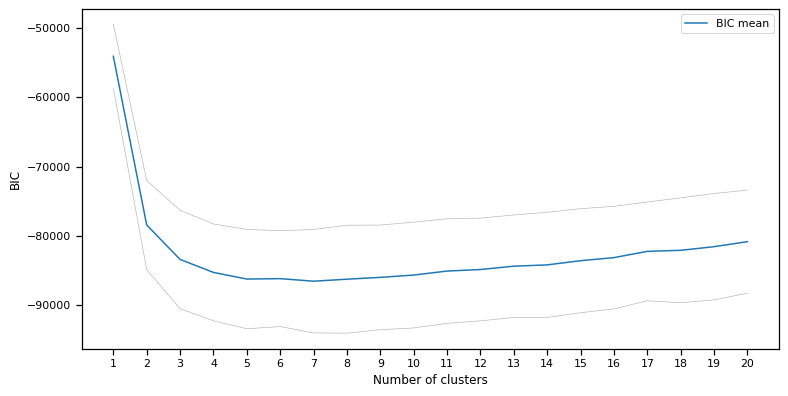

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=90)
BICmean = np.mean(BIC,axis=1)
BICstd = np.std(BIC,axis=1)
normBICmean = (BICmean-np.mean(BICmean))/np.std(BICmean)
normBICstd = np.std(normBICmean)
#plt.plot(np.arange(kmax)+1,(BIC-np.mean(BIC))/np.std(BIC),label='Raw BIC')
plt.plot(np.arange(NK)+1,BICmean,label='BIC mean')
plt.plot(np.arange(NK)+1,BICmean+BICstd,color=[0.7]*3,linewidth=0.5)
plt.plot(np.arange(NK)+1,BICmean-BICstd,color=[0.7]*3,linewidth=0.5)
plt.ylabel('BIC')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(NK)+1)
plt.legend()

In [54]:
np.argmin(BICmean)+1

7